A notebook to illustrate :
   
   * reading in with Butler of postISR images
   * plotting the postage stamp  images produced at WFS analysis stage 
   * 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay
from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg


from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [3]:
class calcMetrics():

    def loadZernikeData(self, opdZkFilePath, wfsZkFilePath):

        opdZkData = np.loadtxt(opdZkFilePath)
        wfsZkData = np.loadtxt(wfsZkFilePath)

        return opdZkData, wfsZkData


    def calcSSR(self, opdZkData, wfsZkData):

        zerDiffSqByField = np.sum((wfsZkData - opdZkData)**2, axis=1)
        zerDiffSqTotal = np.sum(zerDiffSqByField)

        return zerDiffSqByField, zerDiffSqTotal



In [11]:
!ls 

ls: cannot access dataDir: No such file or directory


In [12]:
# Read in the Zernike comparison between wfs and opd 


# for lsst-dev01 it would be 
#dataDir = '/home/scichris/comcam/sep_10/'
dataDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSep/sep_10/'

# It could be other separations, in this example it's just the one 
# that corresponds to 10% of the size of the amplifier 
sepArr = [10]

# initialize metrics class 
calcMagMetrics = calcMetrics()

N = len(sepArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
    
for sep in sepArr :

    print(sep)
    opdZkFilePath = os.path.join(dataDir, 'opd.zer.sep.%d'%sep)
    wfsZkFilePath = os.path.join(dataDir, 'wfs.zer.sep.%d'%sep)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))



10


In [15]:
# Read in the postISR image using the Butler 

focalType = 'extra'  # choose whether extra or intra focal image
obsIdDic = {'intra':9006001,  'extra':9006002} 
obsId = obsIdDic[focalType]

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
detector = 'S00'

sensor = raft+'_S'+detector 

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}
detNum = detNumDict[detector]

data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}


# Read each figure as a postage stamp, store data to an array 
images = {}
for sep in sepArr:
    print('\nReading data from')
    print(dataDir)
    repo_dir = os.path.join(dataDir, 'input/rerun/run1')
    butler = dafPersist.Butler(repo_dir)

    # show what keys are needed by the `postISRCCD` data type.... 
    # butler.getKeys('postISRCCD')
    # yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
    post = butler.get('postISRCCD', **data_id) 
    
    # store in a dictionary
    images[sep] = post.image.array
    
    


Reading data from
/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpSep/sep_10/


/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log10


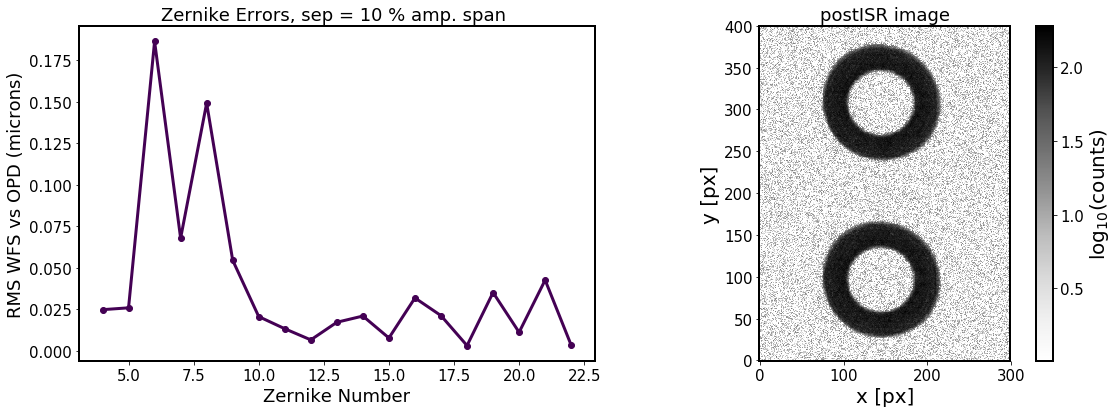

In [25]:
# print Zernikes and image data 

# select the actual donut position...
xmin,xmax = 1625,1925
ymin,ymax = 750,1150

#  plot the Zernikes 
for i in range(len(sepArr)):
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    
    ax[0].plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Sep = %d%%' % sepArr[i],color = cmap(colors[i]))

    ax[0].set_xlabel('Zernike Number', size=18)
    ax[0].set_ylabel('RMS WFS vs OPD (microns)', size=18)
    ax[0].set_title('Zernike Errors, sep = %d %% amp. span '%sepArr[i], size=18)
    
    # plot the postage stamp
    img = ax[1].imshow(np.log10(images[sepArr[i]][ymin:ymax, xmin:xmax]), vmin = 0.01,cmap=cm.get_cmap('Greys'),
              origin='lower')
    cbar= plt.colorbar(mappable=img)
    cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    ax[1].set_title('postISR image')
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')

    plt.tight_layout()
    #plt.savefig('StarSep_singleAmp_rmswfs_opd_postIsr_sep%d.png'%sepArr[i],bbox_inches='tight',
    #           dpi=150)

In [37]:
type(sepArr[0])

int

/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


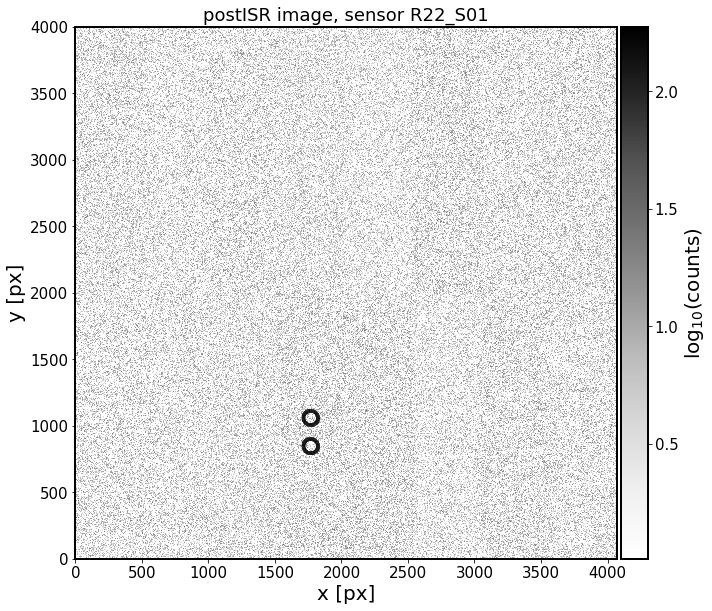

In [41]:
# print the entire CCD R22_S01 postISR image data

# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar


for i in range(len(sepArr)):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    
    # plot the postage stamp
    img = ax.imshow(np.log10(images[sepArr[i]]), vmin = 0.01,cmap=cm.get_cmap('Greys'),
              origin='lower')
    cbar= colorbar(mappable=img)
    cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title('postISR image, sensor %s'%sensor)
    plt.tight_layout()
  

extra_singleSciImg_sensor-R22_S01_star-0.txt
extra_singleSciImg_sensor-R22_S01_star-1.txt
extra_imgDeblend_full_sensor-R22_S01_star-0.txt
extra_imgDeblend_full_sensor-R22_S01_star-1.txt
extra_imgDeblend_resized_sensor-R22_S01_star-0.txt
extra_imgDeblend_resized_sensor-R22_S01_star-1.txt


Text(0.45, 0.92, 'R22_S01 extra')

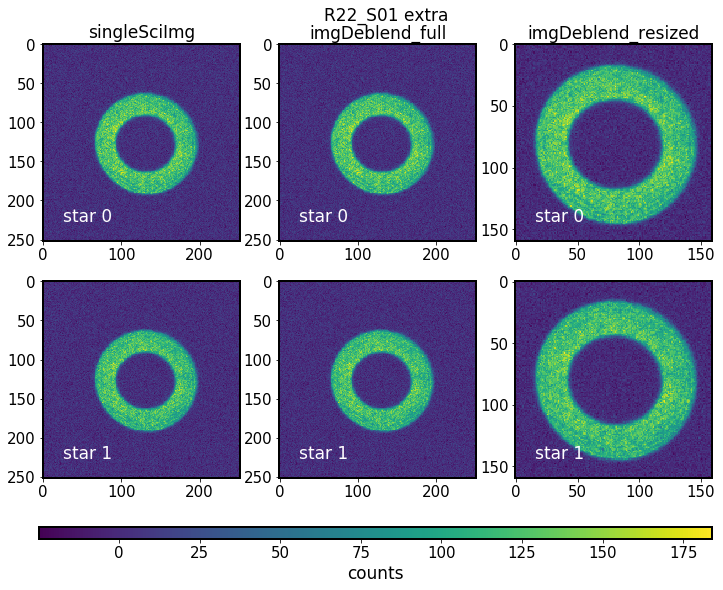

In [34]:
%matplotlib inline

#plot postage image stamps at various steps of analysis 
postageImgDir = os.path.join(dataDir,'postage')


raft = 'R22' # the ComCam raft 
imgType = ['singleSciImg','imgDeblend_full', 'imgDeblend_resized']
chip = '01'
sensor = raft+'_S'+chip

focalType = 'extra'
Nstars = 2
fig,ax = plt.subplots(Nstars,len(imgType),figsize=(12,4*Nstars))


for col in range(len(imgType)): # columns : each imgType is one column 
    ax[0,col].set_title(imgType[col], fontsize=17)
    for row in range(Nstars): # Nstars   rows : one per star
        fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)
        #print(fname)
        for x in os.listdir(postageImgDir):
            if x.startswith(fname): 
                print(x)
                fname = x
        image = np.loadtxt(postageImgDir+'/'+fname)
        if image.ndim == 2  :
            mappable = ax[row,col].imshow(image)
            ax[row,col].text(0.1,0.1,'star %d'%(row) , 
                             fontsize=17, color='white', transform=ax[row,col].transAxes)
        else:
            ax[row,col].remove()
            ax[row,col].text(0.2,0.5, 'image.ndim < 2 ',fontsize=15,
                        transform=ax[row,col].transAxes)
            
# that's for vertical cbar on the right 
#cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])     #  (x0 ,y0  , dx,  dy )  
#cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='vertical')      

# that's for horizontal cbar on the bottom 
cbar_ax = fig.add_axes([0.12, 0.02, 0.78, 0.02])     #  (x0 ,y0  , dx,  dy )  
cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='horizontal')                    
cbar.set_label(label='counts',weight='normal', fontsize=17)

# calculate the separation in units of donut radii ... 
# amplifierSpanPx = 2048 # in pixels
# donutPxRadius = 66 # in pixels 
# sepInPx = starSep*0.01*amplifierSpanPx
# sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

#figtitle= 'Sep=%.2f '%sepInRadii+r'$R_{\mathrm{Donut}}$, '+ \
#r'$\Delta =%d$mag, ' % (16-mag)+sensor+' '+focalType+ '-focal, '+when
figtitle = sensor + ' ' + focalType
fig.text(0.45,0.92,figtitle, fontsize=17)
#plt.savefig('gaia_gMagGt11_R22only_'+sensor+'_'+focalType+'_postageImg_.png', bbox_inches='tight', dpi=100)

The `singleSciImg`,  `imgDeblend_full` , `imgDeblend_resized` correspond to three stages of the preparation of stellar images in the WFS pipeline in https://github.com/lsst-ts/ts_wep/blob/5006a077744a27a7d783908feedc559cf4844595/python/lsst/ts/wep/WepController.py#L370